In [ ]:
import os
# os.chdir("참가자분들 각각의 데이터 경로 입력")

import numpy as np #데이터 처리
import pandas as pd #데이터 처리
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.model_selection import GridSearchCV #모델링
from sklearn.ensemble import RandomForestRegressor #모델링

from datetime import datetime

pd.set_option('display.max_rows', 5000)

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
train['date2'] = pd.to_datetime(train['date'])
train['weekday'] = train['date2'].dt.weekday
train = pd.get_dummies(train,columns=['weekday'])
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])
del train['date2']
del test['date2']

In [ ]:
train['in_out'].value_counts()
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [ ]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

In [ ]:
train22=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

cor=train22.corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [ ]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

In [ ]:
# 해당 주요 장소의 임의 지역 위도, 경도

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [ ]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [ ]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])

In [ ]:
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

In [ ]:
#데이터 불러오기
# raining=pd.read_csv("기상청데이터.csv",encoding='EUC-KR',engine='python')
raining=pd.read_csv("기상청데이터.csv",engine='python')
#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

raining.head()

In [ ]:
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 

raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>=6) & (raining['time']<12)  ]
rain2

In [ ]:
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("rain3.csv")

rain3=pd.read_csv("rain3.csv")

# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3= rain3.fillna(0.00000)
rain3

In [ ]:
train2=pd.merge(train,rain3,how='left',on=['dist_name','date'])
test2=pd.merge(test,rain3,how='left',on=['dist_name','date'])
train2

In [ ]:
train2 = pd.get_dummies(train2,columns=['dist_name'])
test2 = pd.get_dummies(test2,columns=['dist_name'])

train2.shape, test2.shape, train.shape, test.shape

In [ ]:
# input_var=['in_out','latitude', 'longitude', '68a', '810a', '1012a', '68b', '810b', '1012b',
#            'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
#            'dis_jeju', 'dis_gosan','dis_seongsan', 'dis_po','기온(°C)', '강수량(mm)',            
#            'dist_name_gosan', 'dist_name_jeju','dist_name_po', 'dist_name_seongsan']

# 상관계수  0.01 보다 큰 피처들(15개)   --> RMSE: 2.7888439380810235
# 상관계수  0.001 보다 큰 피처들(17개)  --> RMSE: 2.7990497959648586

# 상관계수  절대값이 0.002 보다 큰 피처들(21개)  --> RMSE : test score 2.42520
#           17개에 아래 4개 피쳐 추가함
#             'weekday_0',         
#             'weekday_1',         
#             'weekday_2',
#             'weekday_3',

input_var=[ 'bus_route_id',
            'in_out',            
            'station_code',      
            'latitude', 
            'longitude',
            'weekday_0',
            'weekday_1',
            'weekday_2',
            'weekday_3',           
            '68a',              
            '810a',              
            '1012a',
            '68b',               
            '810b',              
            '1012b', 
            'dis_jeju',
            'dis_po', 
            'dist_name_gosan',            
            'dist_name_jeju',
            'dist_name_po',
            'dist_name_seongsan']  

target=['18~20_ride']

In [ ]:
X_train=train2[input_var]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test2[input_var]

X_train.shape, y_train.shape

In [76]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}

start_time = datetime.now()

# Create a based model
rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

print('grid_search time taken:',datetime.now() - start_time) # grid_search time taken: 0:02:07.198093
#해당 코드 실행시간 2분 ~ 3분 소요

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

grid_search time taken: 0:02:06.565888


{'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

X_train.shape, y_train.shape, X_test.shape

In [82]:
# train 데이터내에서 다시 train: 70% , test : 30%  데이터 추출
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

def get_train_test_split(X_train, y_train, test_size=0.3, random_state=0) :
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                       test_size=test_size, random_state=random_state)
    print('X_train:',X_train.shape)
    print('X_test:',X_test.shape)
    return  X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train: (373880, 21)
X_test: (41543, 21)


In [83]:
# best_params_를 통해서 나온 값을 투입
rf = RandomForestRegressor(max_features=3,min_samples_leaf=2,min_samples_split=2,n_estimators=200,random_state=1217)
# rf = RandomForestRegressor(max_features=5,min_samples_leaf=2,min_samples_split=2,n_estimators=500,random_state=1217)

# rf = RandomForestRegressor(max_features=3,min_samples_leaf=2,min_samples_split=2,n_estimators=100,random_state=1217)
# train RMSE: 2.5054126217303216  , score :2.46


# rf = RandomForestRegressor(max_features=5,min_samples_leaf=2,min_samples_split=2,n_estimators=100,random_state=1217)
# RMSE: 2.5425250784597417

start_time = datetime.now()
print('start_time:',start_time)

rf.fit(X_train,y_train) #학습 

print('RandomForestRegressor time taken:',datetime.now() - start_time) # 0:01:44.079289

pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))

print('RandomForestRegressor RMSE:',rmse)   #   train rmse: 2.5322528363253087  , test_size=0.1


# test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

# test[['id','18~20_ride']].to_csv("2019-12-04-RF.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다
#  2019-12-03    RMSE: 2.54572
#  2019-12-04    RMSE: 2.42520

X_train.shape

#  |상관계수| > 0.002 (21개 , weekday_0~3 4개 추가)              -->   RMSE  train: 2.5322528363253087 , test score: 2.42520    
#  |상관계수| > 0.002 (17개)                                     -->   RMSE  train: 2.537708608500639  , 성능하락
##  |상관계수| > 0.002 (23개 , weekday_0~3,기온,강수량  6개 추가) -->   RMSE  train: 2.624203398422346  , 성능하락 



start_time: 2019-12-05 15:56:07.244187
RandomForestRegressor time taken: 0:01:39.256588
RandomForestRegressor RMSE: 2.5322528363253087


(373880, 21)

In [87]:
# 제출

#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]


start_time = datetime.now()
print('start_time:',start_time)

rf.fit(X_train,y_train) #학습 

print('RandomForestRegressor time taken:',datetime.now() - start_time) # 0:01:44.079289
# 예측 결과 파일로 저장

test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

test[['id','18~20_ride']].to_csv("2019-12-05-RF-final.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다
#  2019-12-03    RMSE: 2.54572
#  2019-12-04    RMSE: 2.42520


start_time: 2019-12-05 16:06:01.504286
RandomForestRegressor time taken: 0:01:39.861845


In [88]:
minus= test[test['18~20_ride'] < 0]
minus
#  No minus data


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,1012a,68b,810b,1012b,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,18~20_ride


In [368]:
round = np.round(test['18~20_ride'].values) 
round
# 성능 저하

array([ 8., 10.,  3., ...,  0.,  1.,  0.])

###  이상치 제거  : 성능 저하

In [309]:
import numpy as np

def get_outlier(df=None, weight=1.5):
    # y_train의  1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
   
    quantile_25 = np.percentile(y_train.values, 25)
    quantile_75 = np.percentile(y_train.values, 99.7)
    print('quantile_25:',quantile_25,'quantile_75:',quantile_75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    print('lowest_val:',lowest_val ,'highest_val:',highest_val)
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = y_train[(y_train['18~20_ride'] < lowest_val) | (y_train['18~20_ride'] > highest_val)].index
    return outlier_index
    

In [310]:
#전체 데이터에서 이상치 제거
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

outlier_index = get_outlier(df=y_train, weight=1.5)
print('이상치 데이터 인덱스:', len(outlier_index))
X_train.drop(outlier_index, axis=0, inplace=True)
y_train.drop(outlier_index, axis=0, inplace=True)
X_train.shape,y_train.shape

quantile_25: 0.0 quantile_75: 35.0
lowest_val: -52.5 highest_val: 87.5
이상치 데이터 인덱스: 143


((415280, 21), (415280, 1))

In [311]:
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=X_train.iloc[train_list,:]

y_train=y_train.iloc[train_list,:]

X_train.shape, y_train.shape

((4153, 21), (4153, 1))

In [312]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}

start_time = datetime.now()

# Create a based model
rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

print('grid_search time taken:',datetime.now() - start_time) # grid_search time taken: 0:02:07.198093
#해당 코드 실행시간 2분 ~ 3분 소요

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

grid_search time taken: 0:02:01.225464


{'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 100}

In [313]:
#전체 데이터에서 이상치 제거
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

outlier_index = get_outlier(df=y_train, weight=1.5)
print('이상치 데이터 인덱스:', len(outlier_index))
X_train.drop(outlier_index, axis=0, inplace=True)
y_train.drop(outlier_index, axis=0, inplace=True)
X_train.shape,y_train.shape

quantile_25: 0.0 quantile_75: 35.0
lowest_val: -52.5 highest_val: 87.5
이상치 데이터 인덱스: 143


((415280, 21), (415280, 1))

In [314]:
# train 데이터내에서 다시 train: 70% , test : 30%  데이터 추출
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

def get_train_test_split(X_train, y_train, test_size=0.3, random_state=0) :
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                       test_size=test_size, random_state=random_state)
    print('X_train:',X_train.shape)
    print('X_test:',X_test.shape)
    return  X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.3, random_state=0)

X_train: (290696, 21)
X_test: (124584, 21)


In [316]:
# best_params_를 통해서 나온 값을 투입
# rf = RandomForestRegressor(max_features=3,min_samples_leaf=2,min_samples_split=2,n_estimators=200,random_state=1217)
# rf = RandomForestRegressor(max_features=3,min_samples_leaf=3,min_samples_split=2,n_estimators=500,random_state=1217)
rf = RandomForestRegressor(max_features=5,min_samples_leaf=2,min_samples_split=6,n_estimators=100,random_state=1217)

start_time = datetime.now()
print('start_time:',start_time)

rf.fit(X_train,y_train) #학습 

print('RandomForestRegressor time taken:',datetime.now() - start_time) 

pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))

print('RandomForestRegressor RMSE:',rmse)   #   train rmse:   , test_size=0.1


# test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

# test[['id','18~20_ride']].to_csv("2019-12-04-RF.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다
#  2019-12-03    RMSE: 2.54572
#  2019-12-04    RMSE: 2.42520

X_train.shape

#  |상관계수| > 0.002 (21개 , weekday_0~3 4개 추가)              -->   RMSE  train: 2.5322528363253087 , test score: 2.42520    
#  |상관계수| > 0.002 (17개)                                     -->   RMSE  train: 2.537708608500639  , 성능하락
#  |상관계수| > 0.002 (23개 , weekday_0~3,기온,강수량  6개 추가) -->   RMSE  train: 2.624203398422346  , 성능하락 

#  IQR 사용 이상치 제거 후 :  train RMSE: 0.4930277636540964   --->  test score : 4.366888762   성능하락

start_time: 2019-12-05 11:05:41.400680
RandomForestRegressor time taken: 0:00:50.463420
RandomForestRegressor RMSE: 2.398025812082043


(290696, 21)

In [317]:
X_test=test2[input_var]
X_test.shape

(228170, 21)

In [318]:
test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

test[['id','18~20_ride']].to_csv("2019-12-05-RF_outlier.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다

In [375]:
y_train['18~20_ride'].value_counts()
# y_train

0.0      266902
1.0       39798
2.0       21342
3.0       12246
4.0        7728
5.0        5332
6.0        3882
7.0        2852
8.0        2061
9.0        1672
10.0       1271
11.0       1064
12.0        888
13.0        724
14.0        584
15.0        553
16.0        456
17.0        414
18.0        360
19.0        346
20.0        298
21.0        238
22.0        209
23.0        194
24.0        181
26.0        176
25.0        144
27.0        143
28.0        127
29.0        113
30.0        105
31.0         89
32.0         75
35.0         72
34.0         69
33.0         67
38.0         61
36.0         56
37.0         55
39.0         50
41.0         48
44.0         47
42.0         40
43.0         37
40.0         34
47.0         32
45.0         32
46.0         31
50.0         23
53.0         22
49.0         22
58.0         21
51.0         20
52.0         20
55.0         20
61.0         19
56.0         19
48.0         17
54.0         17
57.0         16
65.0         15
60.0         13
64.0    

### 로그변환  : 성능 저하

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000161833761C8>]],
      dtype=object)

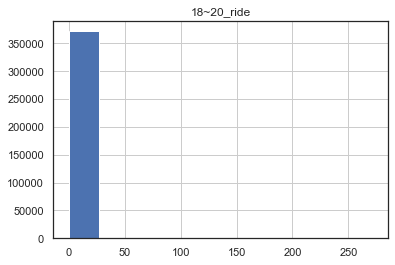

In [203]:
y_train.hist()

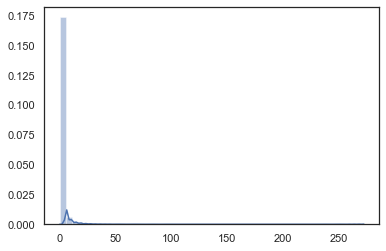

In [204]:
sns.distplot(y_train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016186DB9D88>]],
      dtype=object)

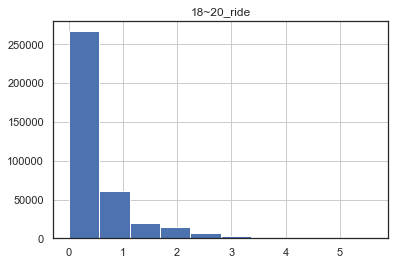

In [206]:
y_log_train = np.log1p(y_train)
# y_log_test = np.log1p(y_test)
y_log_train.hist()

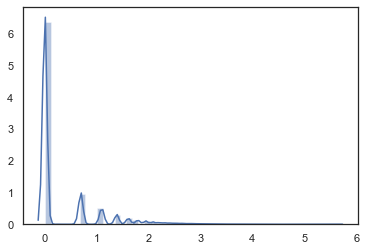

In [207]:
sns.distplot(y_log_train)

In [212]:
# y_train 의 로그변환
X_train=train2[input_var]
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train.shape[0])), int(round(X_train.shape[0]*0.01,0)) )

X_train=train2[input_var]
X_train=X_train.iloc[train_list,:]
y_train=train2[target]
y_train=y_train.iloc[train_list,:]

X_test=test2[input_var]

y_log_train = np.log1p(y_train)
y_train = y_log_train

X_train.shape, y_train.shape

((4154, 21), (4154, 1))

In [213]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100, 200,500]
}

start_time = datetime.now()

# Create a based model
rf = RandomForestRegressor(random_state=1217) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(X_train, y_train)

print('grid_search time taken:',datetime.now() - start_time) # grid_search time taken: 0:02:07.198093
#해당 코드 실행시간 2분 ~ 3분 소요

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

grid_search time taken: 0:01:56.069183


{'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 500}

In [214]:
#전체 데이터로 적용
X_train=train2[input_var]
y_train=train2[target]

X_test=test2[input_var]

y_log_train = np.log1p(y_train)
y_train = y_log_train

X_train.shape, y_train.shape, X_test.shape

((415423, 21), (415423, 1), (228170, 21))

In [215]:
# train 데이터내에서 다시 train: 70% , test : 30%  데이터 추출
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

def get_train_test_split(X_train, y_train, test_size=0.3, random_state=0) :
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                       test_size=test_size, random_state=random_state)
    print('X_train:',X_train.shape)
    print('X_test:',X_test.shape)
    return  X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_split(X_train, y_train, test_size=0.1, random_state=0)

X_train: (373880, 21)
X_test: (41543, 21)


In [216]:
# best_params_를 통해서 나온 값을 투입
# rf = RandomForestRegressor(max_features=3,min_samples_leaf=2,min_samples_split=2,n_estimators=200,random_state=1217)
rf = RandomForestRegressor(max_features=5,min_samples_leaf=2,min_samples_split=6,n_estimators=500,random_state=1217)
# rf = RandomForestRegressor(max_features=2,min_samples_leaf=2,min_samples_split=2,n_estimators=100,random_state=1217)

start_time = datetime.now()
print('start_time:',start_time)

rf.fit(X_train,y_train) #학습 

print('RandomForestRegressor time taken:',datetime.now() - start_time) 

pred = rf.predict(X_test)

pred = np.expm1(pred)
y_test = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_test,pred))

print('RandomForestRegressor RMSE:',rmse)   #   train rmse:   , test_size=0.1


# test['18~20_ride'] = rf.predict(X_test) #예측값 생성 후, test['18~20_ride']에 집어 넣는다.

# test[['id','18~20_ride']].to_csv("2019-12-04-RF.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다
#  2019-12-03    RMSE: 2.54572
#  2019-12-04    RMSE: 2.42520

# X_train.shape

#  |상관계수| > 0.002 (21개 , weekday_0~3 4개 추가)              -->   RMSE  train: 2.5322528363253087 , test score: 2.42520    
#  |상관계수| > 0.002 (17개)                                     -->   RMSE  train: 2.537708608500639  , 성능하락
#  |상관계수| > 0.002 (23개 , weekday_0~3,기온,강수량  6개 추가) -->   RMSE  train: 2.624203398422346  , 성능하락 

# y_train 로그변환 후 -->  RMSE train: 2.8086208131628885 , 성능하락

start_time: 2019-12-05 09:45:19.622930
RandomForestRegressor time taken: 0:05:12.255893
RandomForestRegressor RMSE: 2.8086208131628885


(373880, 21)

In [218]:
### 상관 계수

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
df = train2
df_corr = df.corr()
print(df_corr[np.abs(df_corr['18~20_ride']) >0.02]['18~20_ride'])

# fig, ax = plt.subplots()
# fig.set_size_inches(40, 40)
# sns.heatmap(df_corr,cmap='RdYlGn_r', annot=True)
# train.shape
# df.columns

bus_route_id         -0.143702
in_out                0.022116
station_code          0.034360
latitude              0.079261
longitude            -0.021368
6~7_ride              0.262173
7~8_ride              0.371751
8~9_ride              0.445316
9~10_ride             0.494085
10~11_ride            0.512666
11~12_ride            0.569747
6~7_takeoff           0.178353
7~8_takeoff           0.219430
8~9_takeoff           0.274360
9~10_takeoff          0.295875
10~11_takeoff         0.290691
11~12_takeoff         0.313540
18~20_ride            1.000000
68a                   0.394406
810a                  0.538263
1012a                 0.616721
68b                   0.252626
810b                  0.334714
1012b                 0.344370
dis_jeju             -0.120976
dis_po                0.026983
dist_name_gosan      -0.044140
dist_name_jeju        0.101272
dist_name_po         -0.053011
dist_name_seongsan   -0.053016
Name: 18~20_ride, dtype: float64


In [85]:
test = pd.read_csv("test.csv")
test['18~20_ride'] = sub_preds
test[['id','18~20_ride']].to_csv("2019-12-03_.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 내보낸다

# Score : 2.728693065 